In [ ]:
# Install the MNE library for neurophysiological data analysis
!pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Installing MNE library...
Libraries imported successfully.
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Attempting to load files:
 PSG: /content/drive/MyDrive/sleep-data/SC4001E0-PSG.edf
 Hypnogram: /content/drive/MyDrive/sleep-data/SC4001EC-Hypnogram.edf


/tmp/ipython-input-2926578980.py:44: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations, verbose=False)



Data loaded and annotations attached successfully! 👍

--- DATASET INFORMATION ---
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: <subject_info | his_id: X, sex: 2, first_name: Female, last_name: 33yr>
>

--- AVAILABLE CHANNELS ---
['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']

--- ANNOTATION DETAILS ---
The first 5 annotations are:
 <Annotations | 5 segments: Sleep stage 1 (1), Sleep stage 2 (2), Sleep ...>

Description of annotations found: {np.str_('Sleep stage R'), np.str_('Sleep stage 2'), np.str_('Sleep stage 1'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage W'), np.str_('Sleep stage 3')}

Generating plot for the first 60 seconds of data...
Using matplotlib as 2D 

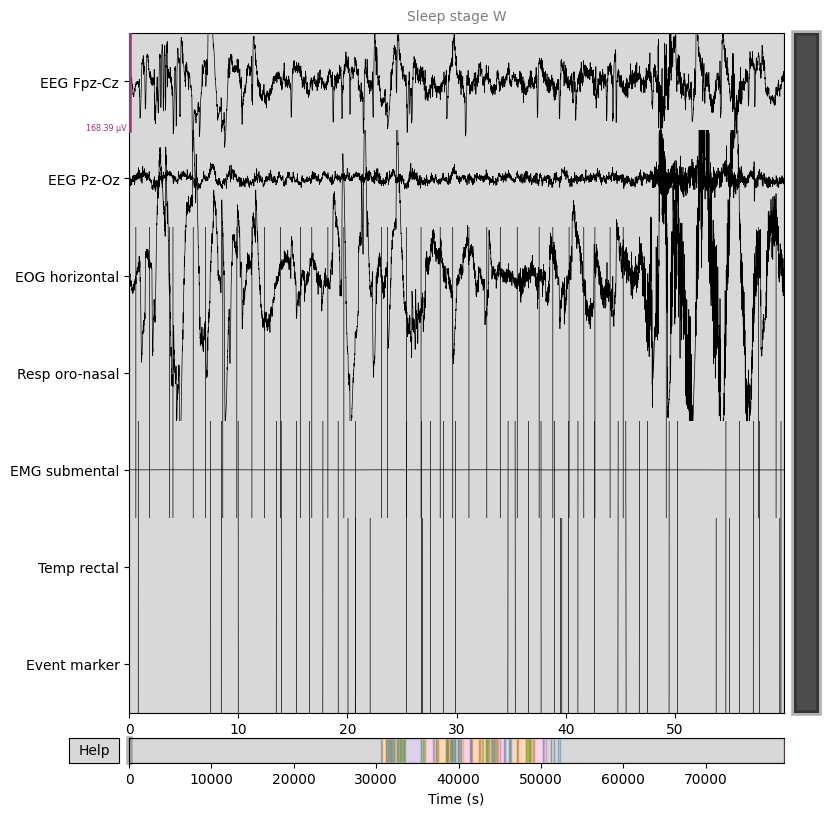

In [ ]:
# --- 1. Install MNE Library ---
# MNE is the primary Python library for analyzing neurophysiological data like EEG.
# The '!' command runs a terminal command from within the Colab notebook.
print("Installing MNE library...")
!pip install mne -q # '-q' makes the installation output quieter

# --- 2. Import Necessary Libraries ---
import mne
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

print("Libraries imported successfully.")

# --- 3. Mount Google Drive ---
# This connects your Colab notebook to your Google Drive, allowing you to access files.
# You will be asked to click a link to authorize the connection.
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# --- 4. Define File Paths ---
# IMPORTANT: You MUST change this 'base_path' to the folder where you saved your files in Google Drive.
# For example, if you created a folder named 'SleepEDF', the path would be:
# "/content/drive/MyDrive/SleepEDF/"
base_path = "/content/drive/MyDrive/sleep-data/" # <-- CHANGE THIS PATH!
psg_file = base_path + "SC4001E0-PSG.edf"
hypnogram_file = base_path + "SC4001EC-Hypnogram.edf"

print(f"Attempting to load files:\n PSG: {psg_file}\n Hypnogram: {hypnogram_file}")

# --- 5. Load the EDF Data Files ---
try:
    # Load the polysomnography (PSG) data
    # preload=True loads all the data into memory at once.
    # stim_channel='auto' helps MNE find event channels correctly.
    raw = mne.io.read_raw_edf(psg_file, preload=True, stim_channel='auto', verbose='error')

    # Load the annotations (sleep stages) from the hypnogram file
    annotations = mne.read_annotations(hypnogram_file)

    # Attach the annotations to the raw data object
    # This synchronizes the sleep stages with the physiological signals.
    raw.set_annotations(annotations, verbose=False)

    print("\nData loaded and annotations attached successfully! 👍")

except Exception as e:
    print(f"\nError loading files: {e}")
    print("Please double-check that the 'base_path' is correct and the files exist.")

# --- 6. Inspect the Loaded Data ---
# It's crucial to check what we've loaded to ensure it's correct.
print("\n--- DATASET INFORMATION ---")
# .info gives a summary: channels, sampling frequency, etc.
print(raw.info)

print("\n--- AVAILABLE CHANNELS ---")
# .ch_names lists all the recorded signals.
print(raw.ch_names)

print("\n--- ANNOTATION DETAILS ---")
# Let's look at the first 5 sleep stage annotations.
print("The first 5 annotations are:\n", annotations[:5])
print("\nDescription of annotations found:", set(annotations.description))

# --- 7. Visualize a Segment of the Data ---
# This plot provides a visual confirmation that the data is loaded correctly.
# It shows the first 60 seconds of the recording. The plot is interactive in Colab.
print("\nGenerating plot for the first 60 seconds of data...")
raw.plot(start=0, duration=60, scalings='auto')
plt.show()

In [ ]:
# --- 1. Select Relevant Channels ---
# We are doing a multimodal analysis, so we select one channel from each key modality.
# EEG: Brain activity ('EEG Fpz-Cz' is a standard choice)
# EOG: Eye movement ('EOG horizontal')
# EMG: Muscle tone ('EMG submental')
# If these exact channels don't exist, you may need to adjust the names based on the
# output of `raw.ch_names` from Step 1.
raw.pick_channels(['EEG Fpz-Cz', 'EOG horizontal', 'EMG submental'])

# --- 2. Apply a Band-Pass Filter ---
# This is a crucial cleaning step. It removes very slow drifts (below 0.3 Hz)
# and high-frequency noise (above 35 Hz) that are not typically related to brain activity.
raw.filter(l_freq=0.3, h_freq=35)
print("Filtered the data and selected relevant channels.")

# --- 3. Create 30-Second Epochs ---
# Sleep stages are scored in 30-second intervals. We will segment our data
# to match these intervals.

# First, we need to map the text annotations to integer IDs that our model can use.
annotation_desc_2_event_id = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3': 4,
    'Sleep stage 4': 4, # N3 and N4 are often combined into a single "deep sleep" stage
    'Sleep stage R': 5  # R is for REM sleep
}

# Create events from the annotations. We ignore any annotations not in our mapping.
events, event_id = mne.events_from_annotations(
    raw, event_id=annotation_desc_2_event_id, chunk_duration=30.
)

# Now, create the epochs based on the events.
# tmin=0, tmax=30. means each epoch starts at the event time and lasts 30 seconds.
# baseline=None means we don't subtract a baseline signal, which is appropriate here.
epochs = mne.Epochs(
    raw=raw,
    events=events,
    event_id=event_id,
    tmin=0,
    tmax=30,
    baseline=None,
    preload=True, # preload=True loads the epoched data into memory
    verbose=False
)

print("\n--- Epochs Information ---")
print(epochs)

# The labels (sleep stages) for each epoch are stored in epochs.events
# The third column of the events array contains the integer ID of the stage.
labels = epochs.events[:, -1]

print(f"\nCreated {len(epochs)} epochs.")
print(f"The first 5 labels are: {labels[:5]}")
print(f"Shape of the epoched data: {epochs.get_data().shape} (epochs, channels, time_points)")

# Let's map the IDs back to names to see the distribution
print("\n--- Sleep Stage Distribution ---")
for stage, stage_id in event_id.items():
    print(f"{stage}: {np.sum(labels == stage_id)} epochs")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Filtered the data and selected relevant channels.
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]

--- Epochs Information ---
<Epochs | 2649 events (all good), 0 – 30 s (baseline off), ~182.0 MiB, data loaded,
 np.st

In [ ]:
from scipy import signal
import numpy as np

# --- 1. Get Data and Parameters ---
# Extract the data from the epochs object
# The shape will be (n_epochs, n_channels, n_times)
data = epochs.get_data()
sfreq = epochs.info['sfreq'] # Sampling frequency
labels = epochs.events[:, -1]

# --- 2. Define Feature Extraction Functions ---

def extract_features(epoch_data):
    """Extracts multimodal features from a single epoch."""
    features = []

    # The channels are in the order we picked them: EEG, EOG, EMG
    eeg = epoch_data[0]
    eog = epoch_data[1]
    emg = epoch_data[2]

    # --- EEG Features: Spectral Power in different bands ---
    win = 4 * sfreq # Window size of 4 seconds
    freqs, psd = signal.welch(eeg, sfreq, nperseg=win)

    # Define EEG bands
    eeg_bands = {
        'delta': [0.5, 4],
        'theta': [4, 8],
        'alpha': [8, 12],
        'beta': [12, 30]
    }

    # Calculate spectral power in each band
    for band in eeg_bands.values():
        freq_ix = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
        band_power = np.sum(psd[freq_ix])
        features.append(band_power)

    # --- EOG Features: Standard Deviation ---
    eog_std = np.std(eog)
    features.append(eog_std)

    # --- EMG Features: Root Mean Square (RMS) ---
    emg_rms = np.sqrt(np.mean(emg**2))
    features.append(emg_rms)

    return features

# --- 3. Loop Through All Epochs to Extract Features ---
print("Extracting features from all epochs...")

all_features = []
for epoch_data in data:
    features = extract_features(epoch_data)
    all_features.append(features)

# Convert list of features to a NumPy array for the model
# This is our feature matrix 'X'
X = np.array(all_features)

# It's good practice for labels to start from 0, so we'll subtract 1
# Original labels: 1,2,3,4,5 -> New labels: 0,1,2,3,4
y = labels - 1

print("Feature extraction complete! ✨")
print("\n--- Feature Matrix 'X' ---")
print(f"Shape of X: {X.shape} (epochs, features)")
print(f"Example feature row (for first epoch):\n{X[0]}")

print("\n--- Labels Vector 'y' ---")
print(f"Shape of y: {y.shape}")
print(f"First 5 labels (now 0-indexed): {y[:5]}")

Extracting features from all epochs...
Feature extraction complete! ✨

--- Feature Matrix 'X' ---
Shape of X: (2649, 6) (epochs, features)
Example feature row (for first epoch):
[3.65742862e-09 4.08094685e-10 3.59349007e-11 4.64648047e-11
 9.44623731e-05 6.11565881e-08]

--- Labels Vector 'y' ---
Shape of y: (2649,)
First 5 labels (now 0-indexed): [0 0 0 0 0]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# --- 1. Split Data into Training and Testing Sets ---
# We'll use an 80/20 split.
# 'test_size=0.2' means 20% of the data will be for testing.
# 'random_state=42' ensures the split is the same every time we run the code.
# 'stratify=y' is very important for imbalanced datasets. It ensures that the
# proportion of sleep stages is the same in both the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("--- Data Split ---")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- 2. Initialize and Train the Random Forest Model ---
# 'n_estimators=100' means the forest will be made of 100 decision trees.
# 'n_jobs=-1' tells scikit-learn to use all available CPU cores, which speeds up training.
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("\nTraining the Random Forest model... (This might take a moment)")

# The .fit() method is where the model learns from the training data.
model.fit(X_train, y_train)

print("\nModel training complete! ✅")

# --- 3. Check a Quick Property of the Trained Model ---
# We can see which features the model thought were most important.
print("\n--- Feature Importances ---")
feature_names = ['EEG_delta', 'EEG_theta', 'EEG_alpha', 'EEG_beta', 'EOG_std', 'EMG_rms']
for name, importance in zip(feature_names, model.feature_importances_):
    print(f"{name}: {importance:.4f}")

--- Data Split ---
Training data shape: (2119, 6)
Testing data shape: (530, 6)

Training the Random Forest model... (This might take a moment)

Model training complete! ✅

--- Feature Importances ---
EEG_delta: 0.2082
EEG_theta: 0.0614
EEG_alpha: 0.0625
EEG_beta: 0.1934
EOG_std: 0.2745
EMG_rms: 0.2000


Predictions made on the test set.

--- Overall Accuracy ---
Model Accuracy: 0.9623 (96.23%)

--- Classification Report ---
              precision    recall  f1-score   support

        Wake       0.99      0.99      0.99       399
          N1       1.00      0.42      0.59        12
          N2       0.84      0.92      0.88        50
       N3/N4       0.97      0.89      0.93        44
         REM       0.79      0.92      0.85        25

    accuracy                           0.96       530
   macro avg       0.92      0.83      0.85       530
weighted avg       0.97      0.96      0.96       530


--- Confusion Matrix ---


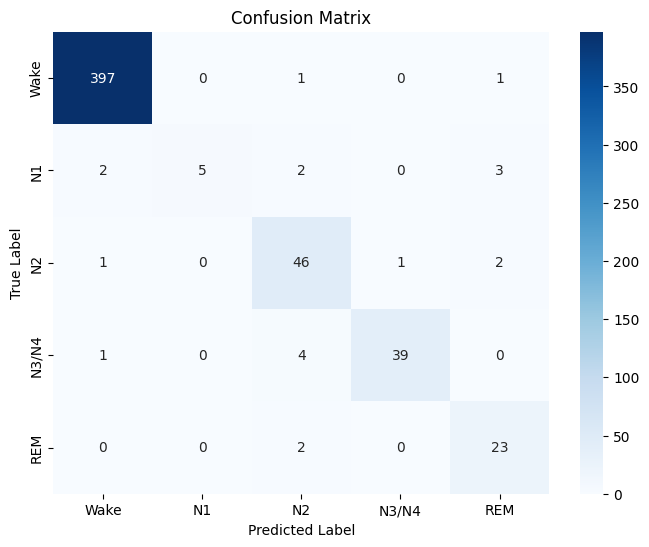

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Make Predictions on the Test Set ---
# Use the trained model to predict the sleep stages for the test data.
y_pred = model.predict(X_test)

print("Predictions made on the test set.")

# --- 2. Calculate and Print Performance Metrics ---
# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Overall Accuracy ---")
print(f"Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Generate the detailed classification report
print("\n--- Classification Report ---")
# We need the names of the stages for the report labels
target_names = [
    'Wake',     # Corresponds to label 0
    'N1',       # Corresponds to label 1
    'N2',       # Corresponds to label 2
    'N3/N4',    # Corresponds to label 3
    'REM'       # Corresponds to label 4
]
print(classification_report(y_test, y_pred, target_names=target_names))

# --- 3. Generate and Plot the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
import numpy as np
from scipy import signal
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mne

# --- 1. Define Subjects and File Paths ---
# IMPORTANT: Add the base names of the 10 subjects you have uploaded.
# The code will automatically add the '-PSG.edf' and '-Hypnogram.edf' parts.
subject_ids = [
    'SC4001E0', 'SC4002E0', 'SC4011E0', 'SC4012E0', 'SC4021E0',
    'SC4022E0', 'SC4031E0', 'SC4032E0', 'SC4041E0', 'SC4042E0'
]
# Make sure this path is the same as in Step 1
base_path = "/content/drive/MyDrive/sleep-data/"

# Initialize lists to store data from all subjects
all_features = []
all_labels = []
groups = [] # This list will store the subject ID for each epoch

# --- 2. Loop Through Each Subject to Load and Process Data ---

for i, subject in enumerate(subject_ids):
    print(f"\n--- Processing Subject {i+1}/{len(subject_ids)}: {subject} ---")
    try:
        # Load data
        psg_file = base_path + subject + "-PSG.edf"
        hyp_file = base_path + subject.replace('E0', 'EC') + "-Hypnogram.edf"

        raw = mne.io.read_raw_edf(psg_file, preload=True, stim_channel='auto', verbose='error')
        annot = mne.read_annotations(hyp_file)
        raw.set_annotations(annot, verbose=False)

        # Preprocessing
        raw.pick_channels(['EEG Fpz-Cz', 'EOG horizontal', 'EMG submental'])
        raw.filter(l_freq=0.3, h_freq=35)

        # Epoching
        annotation_desc_2_event_id = {'Sleep stage W': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5}
        events, event_id = mne.events_from_annotations(raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
        epochs = mne.Epochs(raw=raw, events=events, event_id=event_id, tmin=0, tmax=30, baseline=None, preload=True, verbose=False)

        # Feature Extraction
        epoch_data = epochs.get_data()
        sfreq = epochs.info['sfreq']

        subject_features = []
        for data in epoch_data:
            # Re-using your feature extraction logic
            eeg, eog, emg = data[0], data[1], data[2]
            features = []
            # EEG features
            win = 4 * sfreq
            freqs, psd = signal.welch(eeg, sfreq, nperseg=win)
            eeg_bands = {'delta': [0.5, 4], 'theta': [4, 8], 'alpha': [8, 12], 'beta': [12, 30]}
            for band in eeg_bands.values():
                freq_ix = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
                features.append(np.sum(psd[freq_ix]))
            # EOG feature
            features.append(np.std(eog))
            # EMG feature
            features.append(np.sqrt(np.mean(emg**2)))
            subject_features.append(features)

        # Store results
        all_features.extend(subject_features)
        labels = epochs.events[:, -1] - 1 # 0-indexed labels
        all_labels.extend(labels)
        groups.extend([i] * len(labels)) # Add subject ID for each epoch
        print(f"Successfully processed. Found {len(labels)} epochs.")

    except Exception as e:
        print(f"Error processing {subject}: {e}")

# --- 3. Create Final Dataset ---
X = np.array(all_features)
y = np.array(all_labels)
groups = np.array(groups)

print(f"\n--- Total Dataset Size ---")
print(f"Feature matrix X shape: {X.shape}")
print(f"Labels vector y shape: {y.shape}")
print(f"Groups vector shape: {groups.shape}")


# --- 4. Subject-Aware Train/Test Split ---
# We use GroupShuffleSplit to ensure all epochs from a subject are in the same set
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("\n--- Data Split (Subject-Aware) ---")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Unique subjects in training set: {np.unique(groups[train_idx])}")
print(f"Unique subjects in testing set: {np.unique(groups[test_idx])}")

# --- 5. Train the Improved Random Forest Model ---
# We add `class_weight='balanced'` to handle the imbalanced dataset
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced', # This is the key change for imbalance
    n_jobs=-1
)

print("\nTraining the improved Random Forest model...")
model.fit(X_train, y_train)
print("Model training complete! ✅")

# --- 6. Evaluate the New Model ---
# This part is the same as your original Step 5
print("\n--- Evaluating on the Test Set (Unseen Subjects) ---")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n--- Classification Report ---")
target_names = ['Wake', 'N1', 'N2', 'N3/N4', 'REM']
print(classification_report(y_test, y_pred, target_names=target_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix on Unseen Subjects')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


--- Processing Subject 1/10: SC4001E0 ---


KeyboardInterrupt: 

Found 10 PSG files and 10 Hypnogram files.

--- Processing Subject 1/10: SC4001 ---
  PSG: SC4001E0-PSG.edf
  Hypnogram: SC4001EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2649 epochs.

--- Processing Subject 2/10: SC4002 ---
  PSG: SC4002E0-PSG.edf
  Hypnogram: SC4002EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2828 epochs.

--- Processing Subject 3/10: SC4011 ---
  PSG: SC4011E0-PSG.edf
  Hypnogram: SC4011EH-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2801 epochs.

--- Processing Subject 4/10: SC4012 ---
  PSG: SC4012E0-PSG.edf
  Hypnogram: SC4012EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2848 epochs.

--- Processing Subject 5/10: SC4021 ---
  PSG: SC4021E0-PSG.edf
  Hypnogram: SC4021EH-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2803 epochs.

--- Processing Subject 6/10: SC4022 ---
  PSG: SC4022E0-PSG.edf
  Hypnogram: SC4022EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2754 epochs.

--- Processing Subject 7/10: SC4031 ---
  PSG: SC4031E0-PSG.edf
  Hypnogram: SC4031EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2819 epochs.

--- Processing Subject 8/10: SC4032 ---
  PSG: SC4032E0-PSG.edf
  Hypnogram: SC4032EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2731 epochs.

--- Processing Subject 9/10: SC4041 ---
  PSG: SC4041E0-PSG.edf
  Hypnogram: SC4041EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2568 epochs.

--- Processing Subject 10/10: SC4042 ---
  PSG: SC4042E0-PSG.edf
  Hypnogram: SC4042EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1377099401.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2787 epochs.

--- Total Dataset Size ---
Feature matrix X shape: (27588, 6)
Labels vector y shape: (27588,)

--- Data Split (Subject-Aware) ---
Training data shape: (22192, 6)
Testing data shape: (5396, 6)

Training 

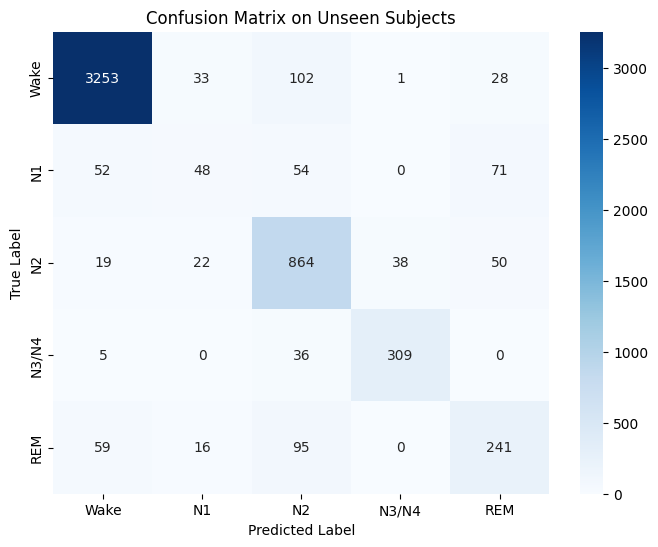

In [ ]:
import os
import numpy as np
from scipy import signal
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mne

# --- 1. Define Path and Automatically Discover Files ---
base_path = "/content/drive/MyDrive/sleep-data/"

# Get a list of all files in the directory
all_files_in_dir = os.listdir(base_path)

# Find all the PSG files
psg_files = sorted([f for f in all_files_in_dir if 'PSG.edf' in f])
# Find all the Hypnogram files
hyp_files = sorted([f for f in all_files_in_dir if 'Hypnogram.edf' in f])

print(f"Found {len(psg_files)} PSG files and {len(hyp_files)} Hypnogram files.")

# Initialize lists to store data from all subjects
all_features = []
all_labels = []
groups = [] # This list will store the subject ID for each epoch

# --- 2. Loop Through Each Discovered PSG File ---

for i, psg_filename in enumerate(psg_files):
    # Extract the base subject identifier (e.g., 'SC4001')
    subject_base_id = psg_filename.split('E')[0]

    print(f"\n--- Processing Subject {i+1}/{len(psg_files)}: {subject_base_id} ---")

    # Find the matching hypnogram file for this subject
    matching_hyp_file = None
    for h_file in hyp_files:
        if h_file.startswith(subject_base_id):
            matching_hyp_file = h_file
            break

    if matching_hyp_file is None:
        print(f"!!! Warning: Could not find a hypnogram for {psg_filename}. Skipping.")
        continue

    # Construct the full file paths
    full_psg_path = os.path.join(base_path, psg_filename)
    full_hyp_path = os.path.join(base_path, matching_hyp_file)

    print(f"  PSG: {psg_filename}")
    print(f"  Hypnogram: {matching_hyp_file}")

    try:
        # Load data
        raw = mne.io.read_raw_edf(full_psg_path, preload=True, stim_channel='auto', verbose='error')
        annot = mne.read_annotations(full_hyp_path)
        raw.set_annotations(annot, verbose=False)

        # Preprocessing
        raw.pick_channels(['EEG Fpz-Cz', 'EOG horizontal', 'EMG submental'])
        raw.filter(l_freq=0.3, h_freq=35)

        # Epoching
        annotation_desc_2_event_id = {'Sleep stage W': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5}
        events, event_id = mne.events_from_annotations(raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
        epochs = mne.Epochs(raw=raw, events=events, event_id=event_id, tmin=0, tmax=30, baseline=None, preload=True, verbose=False)

        # Feature Extraction
        epoch_data = epochs.get_data()
        sfreq = epochs.info['sfreq']

        subject_features = []
        for data in epoch_data:
            eeg, eog, emg = data[0], data[1], data[2]
            features = []
            # EEG features
            win = 4 * sfreq
            freqs, psd = signal.welch(eeg, sfreq, nperseg=win)
            eeg_bands = {'delta': [0.5, 4], 'theta': [4, 8], 'alpha': [8, 12], 'beta': [12, 30]}
            for band in eeg_bands.values():
                freq_ix = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
                features.append(np.sum(psd[freq_ix]))
            # EOG feature
            features.append(np.std(eog))
            # EMG feature
            features.append(np.sqrt(np.mean(emg**2)))
            subject_features.append(features)

        # Store results
        all_features.extend(subject_features)
        labels = epochs.events[:, -1] - 1 # 0-indexed labels
        all_labels.extend(labels)
        groups.extend([i] * len(labels)) # Add subject ID for each epoch
        print(f"  Successfully processed. Found {len(labels)} epochs.")

    except Exception as e:
        print(f"  !!! Error processing {psg_filename}: {e}")

# --- 3. Create Final Dataset ---
X = np.array(all_features)
y = np.array(all_labels)
groups = np.array(groups)

print(f"\n--- Total Dataset Size ---")
print(f"Feature matrix X shape: {X.shape}")
print(f"Labels vector y shape: {y.shape}")

# --- 4. Subject-Aware Train/Test Split ---
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("\n--- Data Split (Subject-Aware) ---")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- 5. Train and Evaluate the Improved Model ---
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

print("\nTraining the improved Random Forest model...")
model.fit(X_train, y_train)
print("Model training complete! ✅")

print("\n--- Evaluating on the Test Set (Unseen Subjects) ---")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n--- Classification Report ---")
target_names = ['Wake', 'N1', 'N2', 'N3/N4', 'REM']
print(classification_report(y_test, y_pred, target_names=target_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix on Unseen Subjects')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

--- Step 0: Installing MNE and importing libraries ---
Setup complete. Libraries imported successfully. ✅

--- Step 1: Mounting Google Drive and finding data files ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 10 PSG files and 10 Hypnogram files.

--- Steps 2 & 3: Processing subjects and extracting features ---

Processing Subject 1/10: SC4001
  Pairing SC4001E0-PSG.edf with SC4001EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2649 epochs.

Processing Subject 2/10: SC4002
  Pairing SC4002E0-PSG.edf with SC4002EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2828 epochs.

Processing Subject 3/10: SC4011
  Pairing SC4011E0-PSG.edf with SC4011EH-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2801 epochs.

Processing Subject 4/10: SC4012
  Pairing SC4012E0-PSG.edf with SC4012EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2848 epochs.

Processing Subject 5/10: SC4021
  Pairing SC4021E0-PSG.edf with SC4021EH-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2803 epochs.

Processing Subject 6/10: SC4022
  Pairing SC4022E0-PSG.edf with SC4022EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2754 epochs.

Processing Subject 7/10: SC4031
  Pairing SC4031E0-PSG.edf with SC4031EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2819 epochs.

Processing Subject 8/10: SC4032
  Pairing SC4032E0-PSG.edf with SC4032EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2731 epochs.

Processing Subject 9/10: SC4041
  Pairing SC4041E0-PSG.edf with SC4041EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2568 epochs.

Processing Subject 10/10: SC4042
  Pairing SC4042E0-PSG.edf with SC4042EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-384767480.py:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  Successfully processed. Found 2787 epochs.

--- Total Dataset Assembled ---
Feature matrix X shape: (27588, 6)
Labels vector y shape: (27588,)

--- Step 4: Splitting data and training the model ---
Training data shape: (19438, 6)
Testing data sha

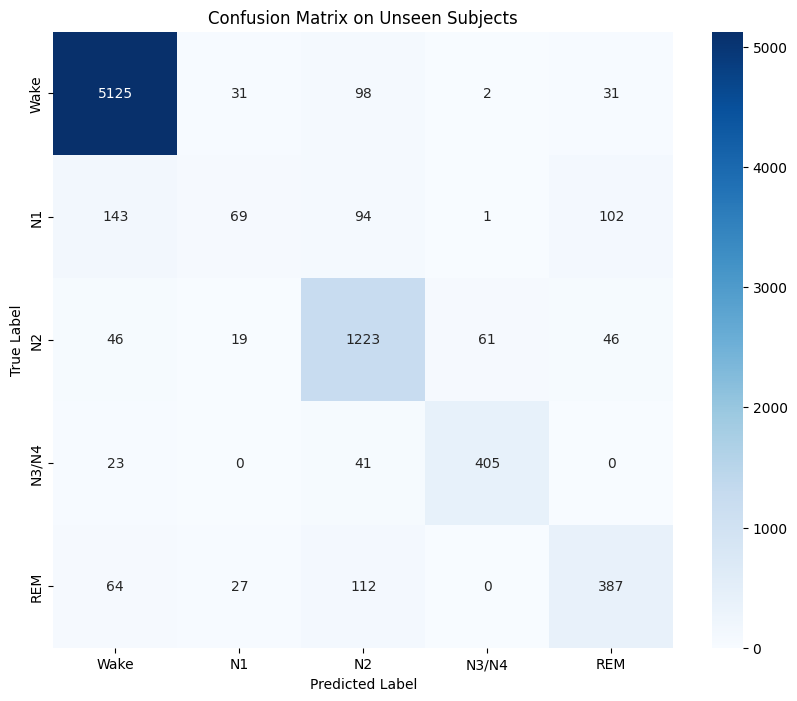

In [ ]:
# ==============================================================================
# STEP 0: SETUP AND INSTALLATIONS
# ==============================================================================
print("--- Step 0: Installing MNE and importing libraries ---")
# The '-q' flag makes the installation output less verbose
!pip install mne -q

import os
import mne
import numpy as np
from scipy import signal
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Setup complete. Libraries imported successfully. ✅")

# ==============================================================================
# STEP 1: MOUNT DRIVE AND DISCOVER DATA FILES
# ==============================================================================
print("\n--- Step 1: Mounting Google Drive and finding data files ---")
drive.mount('/content/drive')

# IMPORTANT: Change this path to the folder where you saved your sleep EDF files.
base_path = "/content/drive/MyDrive/sleep-data/"

# Automatically discover all PSG and Hypnogram files
try:
    all_files_in_dir = os.listdir(base_path)
    psg_files = sorted([f for f in all_files_in_dir if 'PSG.edf' in f])
    hyp_files = sorted([f for f in all_files_in_dir if 'Hypnogram.edf' in f])

    if not psg_files:
        raise FileNotFoundError("No PSG files found in the specified directory.")

    print(f"Found {len(psg_files)} PSG files and {len(hyp_files)} Hypnogram files.")

except FileNotFoundError as e:
    print(f"Error: Could not find the directory '{base_path}'. Please check the path and try again.")
    # Stop execution if the data directory is not found
    exit()

# ==============================================================================
# STEPS 2 & 3: PROCESS EACH SUBJECT AND EXTRACT FEATURES
# ==============================================================================
print("\n--- Steps 2 & 3: Processing subjects and extracting features ---")

# Initialize lists to store data from all subjects
all_features = []
all_labels = []
groups = [] # This list will store a unique ID for each subject's data

# Loop through each discovered PSG file
for subject_index, psg_filename in enumerate(psg_files):
    subject_base_id = psg_filename.split('E')[0]
    print(f"\nProcessing Subject {subject_index + 1}/{len(psg_files)}: {subject_base_id}")

    # Find the corresponding hypnogram file
    matching_hyp_file = next((h for h in hyp_files if h.startswith(subject_base_id)), None)

    if not matching_hyp_file:
        print(f"  !!! Warning: Could not find a hypnogram for {psg_filename}. Skipping.")
        continue

    # Construct the full file paths
    full_psg_path = os.path.join(base_path, psg_filename)
    full_hyp_path = os.path.join(base_path, matching_hyp_file)
    print(f"  Pairing {psg_filename} with {matching_hyp_file}")

    try:
        # Load data
        raw = mne.io.read_raw_edf(full_psg_path, preload=True, stim_channel='auto', verbose='error')
        annot = mne.read_annotations(full_hyp_path)
        raw.set_annotations(annot, verbose=False)

        # --- Preprocessing ---
        raw.pick_channels(['EEG Fpz-Cz', 'EOG horizontal', 'EMG submental'])
        raw.filter(l_freq=0.3, h_freq=35)

        # --- Epoching ---
        annotation_desc_2_event_id = {'Sleep stage W': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5}
        events, _ = mne.events_from_annotations(raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
        epochs = mne.Epochs(raw=raw, events=events, tmin=0, tmax=30, baseline=None, preload=True, verbose=False)

        # --- Feature Extraction ---
        epoch_data = epochs.get_data()
        sfreq = epochs.info['sfreq']

        subject_features = []
        for data in epoch_data:
            eeg, eog, emg = data[0], data[1], data[2]
            features = []
            # EEG features (Power Spectral Density)
            win = 4 * sfreq
            freqs, psd = signal.welch(eeg, sfreq, nperseg=win)
            eeg_bands = {'delta': [0.5, 4], 'theta': [4, 8], 'alpha': [8, 12], 'beta': [12, 30]}
            for band in eeg_bands.values():
                freq_ix = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
                features.append(np.sum(psd[freq_ix]))
            # EOG feature (Standard Deviation)
            features.append(np.std(eog))
            # EMG feature (Root Mean Square)
            features.append(np.sqrt(np.mean(emg**2)))
            subject_features.append(features)

        # Store results for this subject
        all_features.extend(subject_features)
        labels = epochs.events[:, -1] - 1  # Convert to 0-indexed labels
        all_labels.extend(labels)
        groups.extend([subject_index] * len(labels)) # Use the loop index as the subject ID
        print(f"  Successfully processed. Found {len(labels)} epochs.")

    except Exception as e:
        print(f"  !!! Error processing {psg_filename}: {e}")

# Create the final dataset
X = np.array(all_features)
y = np.array(all_labels)
groups = np.array(groups)

print(f"\n--- Total Dataset Assembled ---")
print(f"Feature matrix X shape: {X.shape}")
print(f"Labels vector y shape: {y.shape}")

# ==============================================================================
# STEP 4: MODEL BUILDING AND TRAINING
# ==============================================================================
print("\n--- Step 4: Splitting data and training the model ---")

# Split data into training and testing sets, ensuring subjects are not mixed
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Subjects in training set: {np.unique(groups[train_idx])}")
print(f"Subjects in testing set (unseen by model): {np.unique(groups[test_idx])}")

# Initialize the model, handling class imbalance automatically
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced', # Crucial for imbalanced data
    n_jobs=-1
)

# Train the model
print("\nTraining the Random Forest model... (This may take a few moments)")
model.fit(X_train, y_train)
print("Model training complete! 🚀")

# ==============================================================================
# STEP 5: EVALUATION
# ==============================================================================
print("\n--- Step 5: Evaluating the model's performance ---")

# Make predictions on the unseen test data
y_pred = model.predict(X_test)

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Unseen Subjects: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n--- Classification Report ---")
target_names = ['Wake', 'N1', 'N2', 'N3/N4', 'REM']
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix on Unseen Subjects')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

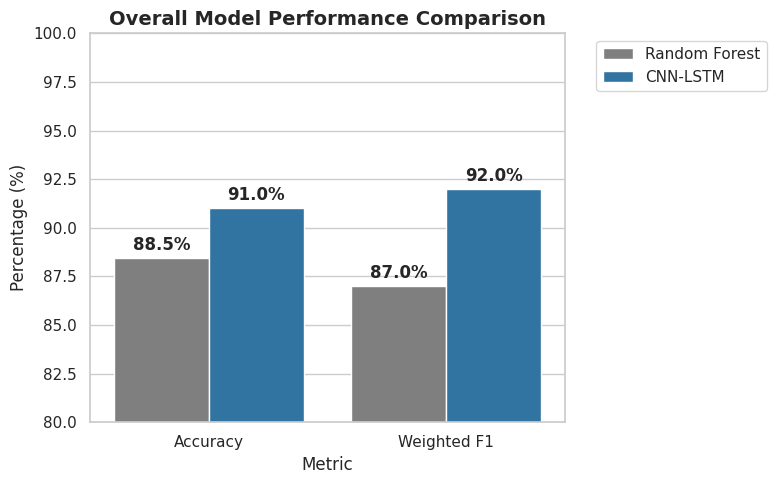

Saved slide_15_overall_comparison.png


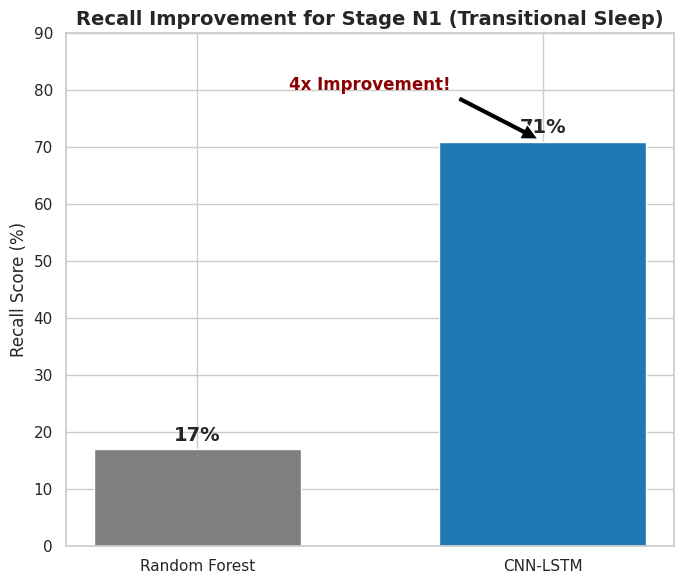

Saved slide_16_n1_improvement.png


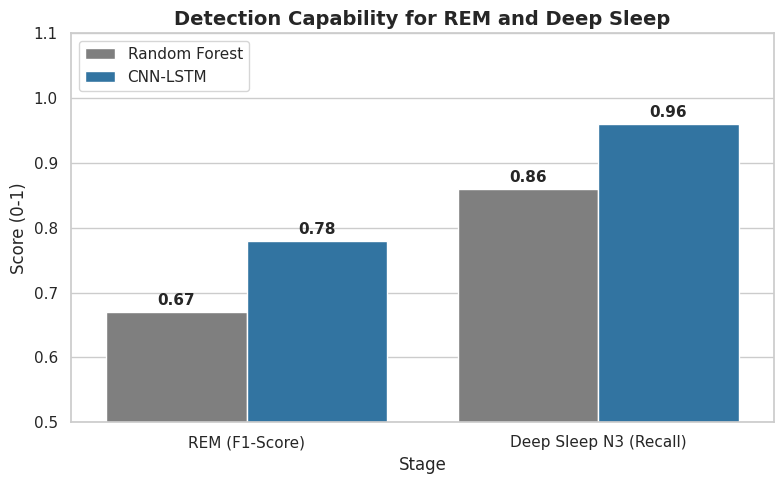

Saved slide_17_rem_n3_analysis.png


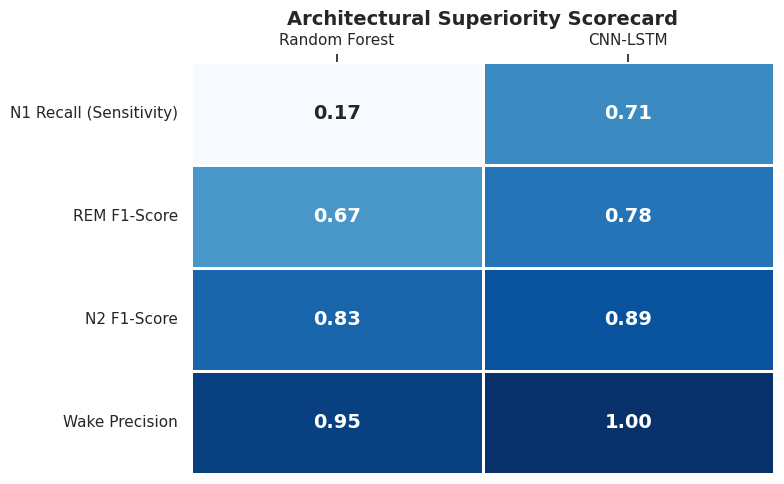

Saved slide_18_summary_heatmap.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style for professional, clean charts
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# Define Colors: Grey for Baseline (RF), Blue for Proposed (CNN-LSTM)
colors = ["#7f7f7f", "#1f77b4"]
custom_palette = sns.set_palette(sns.color_palette(colors))

def save_plot(filename):
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved {filename}")

# ========================================================
# VISUAL 1 (Slide 15): Overall Performance Comparison
# ========================================================
data_overall = {
    'Metric': ['Accuracy', 'Accuracy', 'Weighted F1', 'Weighted F1'],
    'Model': ['Random Forest', 'CNN-LSTM', 'Random Forest', 'CNN-LSTM'],
    'Score': [88.45, 91.00, 87.00, 92.00]
}
df_overall = pd.DataFrame(data_overall)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Metric', y='Score', hue='Model', data=df_overall, palette=colors)

# Add labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=12, fontweight='bold')

plt.ylim(80, 100) # Zoom in to show the difference
plt.title("Overall Model Performance Comparison", fontsize=14, fontweight='bold')
plt.ylabel("Percentage (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
save_plot('slide_15_overall_comparison.png')


# ========================================================
# VISUAL 2 (Slide 16): The "N1 Problem" (Recall Improvement)
# ========================================================
# Focusing strictly on N1 Recall to show the massive jump
models = ['Random Forest', 'CNN-LSTM']
n1_recall = [17, 71] # In percentages

plt.figure(figsize=(7, 6))
bars = plt.bar(models, n1_recall, color=colors, width=0.6)

# Add values
plt.bar_label(bars, fmt='%d%%', padding=3, fontsize=14, fontweight='bold')

# Add an arrow showing improvement
plt.annotate('4x Improvement!',
             xy=(1, 71), xytext=(0.5, 80),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, fontweight='bold', color='darkred', ha='center')

plt.ylim(0, 90)
plt.title("Recall Improvement for Stage N1 (Transitional Sleep)", fontsize=14, fontweight='bold')
plt.ylabel("Recall Score (%)")
save_plot('slide_16_n1_improvement.png')


# ========================================================
# VISUAL 3 (Slide 17): Deep Sleep & REM Stability
# ========================================================
data_specific = {
    'Stage': ['REM (F1-Score)', 'REM (F1-Score)', 'Deep Sleep N3 (Recall)', 'Deep Sleep N3 (Recall)'],
    'Model': ['Random Forest', 'CNN-LSTM', 'Random Forest', 'CNN-LSTM'],
    'Score': [0.67, 0.78, 0.86, 0.96]
}
df_specific = pd.DataFrame(data_specific)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Stage', y='Score', hue='Model', data=df_specific, palette=colors)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=11, fontweight='bold')

plt.ylim(0.5, 1.1)
plt.title("Detection Capability for REM and Deep Sleep", fontsize=14, fontweight='bold')
plt.ylabel("Score (0-1)")
plt.legend(loc='upper left')
save_plot('slide_17_rem_n3_analysis.png')


# ========================================================
# VISUAL 4 (Slide 18): Summary Scorecard Heatmap
# ========================================================
# Creating a heatmap to summarize the "Wins" across difficult categories
summary_data = [
    [0.17, 0.71],  # N1 Recall
    [0.67, 0.78],  # REM F1
    [0.83, 0.89],  # N2 F1
    [0.95, 1.00]   # Wake Precision
]
rows = ['N1 Recall (Sensitivity)', 'REM F1-Score', 'N2 F1-Score', 'Wake Precision']
cols = ['Random Forest', 'CNN-LSTM']

plt.figure(figsize=(8, 5))
sns.heatmap(summary_data, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=cols, yticklabels=rows, linewidths=1, linecolor='white',
            cbar=False, annot_kws={"size": 14, "weight": "bold"})

plt.title("Architectural Superiority Scorecard", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=11, labelbottom = False, bottom=False, top = True, labeltop=True)
save_plot('slide_18_summary_heatmap.png')